# Buoyancy and Precipitation <a class="tocSkip">

- Start with environmental parcel
- Evaporate X g/kg liquid water into parcel (latent heat only?)
- Parcel cools and becomes more moist
- What is new buoyancy of parcel?

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-sample-sounding" data-toc-modified-id="A-sample-sounding-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A sample sounding</a></span><ul class="toc-item"><li><span><a href="#Determining-height-from-pressure" data-toc-modified-id="Determining-height-from-pressure-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Determining height from pressure</a></span></li></ul></li><li><span><a href="#Temperature-and-specific-humidity-after-precipitation" data-toc-modified-id="Temperature-and-specific-humidity-after-precipitation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Temperature and specific humidity after precipitation</a></span></li><li><span><a href="#Buoyancy-after-precipitation" data-toc-modified-id="Buoyancy-after-precipitation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Buoyancy after precipitation</a></span></li></ul></div>

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from os import mkdir
from os.path import exists

## A sample sounding
In order to determine the buoyancy of the parcel, we need to know the environmental density. We use a sounding above Sydney Airport on 12 November 2019.

In [192]:
file = '../soundings/SYDNEY AIRPORT (94767) 12 Nov 2019 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=0)
sounding = sounding.to_numpy()
environment_pressure = sounding[:,0]*units.mbar
environment_temperature = sounding[:,1]*units.celsius
environment_dewpoint = sounding[:,2]*units.celsius

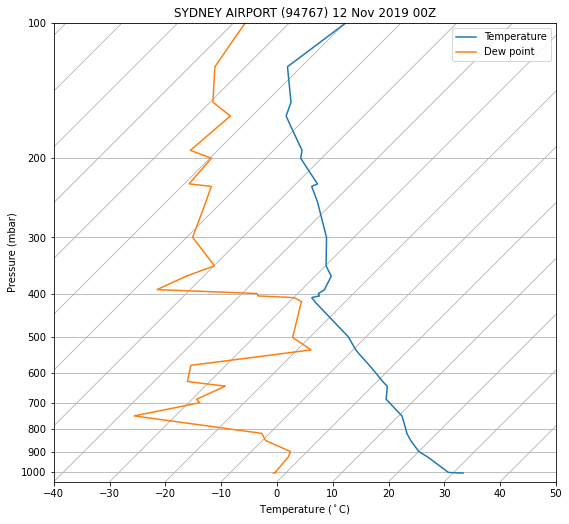

In [193]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, subplot=(1,1,1), rotation=45)
skew.plot(environment_pressure, environment_temperature, label='Temperature')
skew.plot(environment_pressure, environment_dewpoint, label='Dew point')
skew.ax.legend()
skew.ax.set(
    xlabel=r'Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='SYDNEY AIRPORT (94767) 12 Nov 2019 00Z')
plt.show()

### Determining height from pressure
In order to be able to express the buoyancy as a function of height later, we will need to find the height as a function of pressure in the sounding by assuming hydrostatic balance and integrating the hydrostatic equation $$\frac{dz}{dp}=-\frac{1}{\rho g}.$$

In [201]:
# interpolation functions for temperature and dew point
environment_temperature_interp = interp1d(
    environment_pressure, environment_temperature, kind='linear')
environment_dewpoint_interp = interp1d(
    environment_pressure, environment_dewpoint, kind='linear')

def environment_temperature_from_pressure(pressure):
    temperature = environment_temperature_interp(pressure.to(units.mbar).m)
    return temperature*units.celsius

def environment_dewpoint_from_pressure(pressure):
    dewpoint = environment_dewpoint_interp(pressure.to(units.mbar).m)
    return dewpoint*units.celsius

In [204]:
def environment_dzdp(pressure, height):
    pressure = pressure/100*units.mbar
    dewpoint = environment_dewpoint_from_pressure(pressure)
    temperature = environment_temperature_from_pressure(pressure)
    
    specific_humidity = mpcalc.specific_humidity_from_dewpoint(
        pressure, dewpoint)
    mixing_ratio = mpcalc.mixing_ratio_from_specific_humidity(
        specific_humidity)
    density = mpcalc.density(pressure, temperature, mixing_ratio).m
    dzdp = - 1 / (density * 9.8)
    
    return dzdp

sol = solve_ivp(
    environment_dzdp, (1004e2, 100e2), [0], 
    t_eval=np.arange(1004e2, 99e2, -10e2))

In [206]:
interpolated_pressure_from_height = interp1d(np.squeeze(sol.y), sol.t)

def environment_pressure_from_height(height):
    pressure = interpolated_pressure_from_height(height.to(units.meter).m)
    return (pressure*units.pascal).to(units.mbar)

def environment_temperature_from_height(height):
    pressure = environment_pressure_from_height(height)
    temperature = environment_temperature_from_pressure(pressure)
    return temperature

def environment_dewpoint_from_height(height):
    pressure = environment_pressure_from_height(height)
    dewpoint = environment_dewpoint_from_pressure(pressure)
    return dewpoint

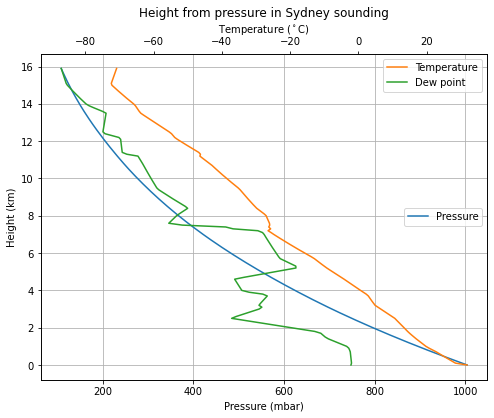

In [231]:
height = np.arange(0, 16e3, 100)*units.meter
pressure = environment_pressure_from_height(height)
temperature = environment_temperature_from_height(height)
dewpoint = environment_dewpoint_from_height(height)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(pressure, height.to(units.km), label='Pressure')
ax.grid()
ax.legend(loc='center right')
ax.set(
    xlabel='Pressure (mbar)',
    ylabel='Height (km)',
    title='Height from pressure in Sydney sounding')
ax2 = ax.twiny()
ax2.plot(temperature, height.to(units.km), color='tab:orange',
         label='Temperature')
ax2.plot(dewpoint, height.to(units.km), color='tab:green', label='Dew point')
ax2.legend()
ax2.set_xlabel(r'Temperature ($^\circ$C)')
plt.show()

## Temperature and specific humidity after precipitation

The increase $dq$ in the parcel's specific humidity is equal to the ratio of the mass of liquid water added to the total mass of the parcel (including the liquid water).

The latent heat required to evaporate the water is
$$ \frac{dQ}{m} = -L~dq$$
and the parcel remains at constant pressure as the heat is added so the change in temperature is
$$
    c_p~dT = -L~dq \\
    \Leftrightarrow \qquad T' = T_E - \frac{L~dq}{c_p}.
$$
We see that $dT$ is independent of the starting temperature.

## Buoyancy after precipitation

If the parcel starts at pressure $p_0$, the buoyant force per unit mass is
$$
\begin{align}
    b &= \frac{\rho_E - \rho_P}{\rho_P} g \\
    &= \frac{T_P - T_E}{T_E} g \\
    &= \frac{\theta_P(p) - \theta_E(p)}{\theta_E(p)} g \\
    &= \frac{\theta_P(p_0) - \theta_E(p)}{\theta_E(p)} g
\end{align}
$$
where the subscript $P$ and $E$ denote the parcel and environment respectively.

At the instant the liquid water is evaporated,
$$
    b = - \frac{L~dq}{c_p T_E} g < 0.
$$